# Histopathologic Cancer Detection: Binary Image Classification

---

## 1. Problem Description

### Project Overview
- **Objective**: Develop an algorithm to identify metastatic cancer in small image patches from digital pathology scans.
- **Dataset**: Modified version of the PatchCamelyon (PCam) dataset, widely used for medical image classification research.

### Dataset Background
- **PCam Dataset**: Originally created to support research on metastasis detection in histopathology images, presenting a binary classification task.
- **Clinical Relevance**: Early detection of metastasis is crucial for cancer diagnosis and treatment, with models like these supporting pathologists in decision-making.

### Task Description
- This is a binary classification problem where each image patch is labeled as:
   - `1` for patches with at least one pixel of tumor tissue in the central 32x32 region.
   - `0` for patches without tumor tissue in the central region.
- The outer area of each patch is not used for labeling but is included to support fully-convolutional models.

### Evaluation Metric
- **Metric**: Area Under the Receiver Operating Characteristic Curve (ROC-AUC).
- **Why ROC-AUC?** It provides insight into how well the model differentiates between classes across thresholds, especially helpful for medical data with class imbalance.

---

## 2. Exploratory Data Analysis (EDA)

### 1. Dataset Structure
- **Training Labels**: Examine `train_labels.csv` to understand dataset structure.
- **Dataset Files**: Outline the dataset components:
   - `train` folder with training images.
   - `test` folder with test images.
   - `train_labels.csv` containing ground truth labels.
   - `sample_submission.csv` as a submission template.

### 2. Image Characteristics
- **Image Dimensions**: Images are small pathology patches; only the central 32x32 pixel region influences the label.
- **Region of Interest**: This central region is essential for classification, while the outer area supports fully-convolutional models.

### 3. Sample Visualization
- **Display Sample Images**: Visualize some positive and negative label patches.
   - Compare cancerous vs. non-cancerous samples, focusing on the central region.

### 4. Label Distribution
- **Class Imbalance**: Plot the distribution of positive and negative labels to understand if class imbalance mitigation is needed.
- Sample image visualization.
- Summary statistics for image characteristics (mean, standard deviation, etc.).
- Normalization Decision:
    Based on the summary statistics, explain needs to use a specific normalization technique (e.g., Z-score normalization).

### 5. Data Generator Setup
- Define and implement the data generator with the chosen normalization method.

---

## 3. Model Building and Training

### 1. Model Selection
- **Model Type**: Convolutional Neural Network (CNN) for binary image classification.
- **Baseline Architecture**: Define a simple CNN architecture as a starting point (e.g., input layer, convolutional layers, pooling layers, fully connected layers, and output).

### 2. Training Setup
- **Loss Function**: Binary cross-entropy for binary classification.
- **Optimizer**: Adam optimizer for training stability.
- **Metrics**: ROC-AUC for model evaluation, as specified by the competition.

### 3. Training Process
- **Batch Generator**: Use a batch generator that loads images directly from the zip file to manage memory.
- **Train the Model**: Set up the training loop and train the model over multiple epochs, tracking performance metrics.

---

## 4. Results

### 1. Training Evaluation
- **Training Curves**: Plot the training and validation accuracy/loss over epochs.
- **ROC-AUC Score**: Calculate and display the ROC-AUC score on the validation set.

### 2. Model Performance
- **Test Set Performance**: Evaluate the trained model on the test set (if available).
- **Comparison with Baseline**: Compare performance with baseline models, if applicable.

---

## 5. Discussion and Conclusion

### 1. Model Insights
- Discuss model performance, key observations, and challenges encountered, such as class imbalance or overfitting.


In [16]:
# using Python 3.9.20
# due to limitations with Tensorflow library

#Import Required Libraries
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [17]:
# Define the path to the zip file and load labels
zip_file_path = r"histopathologic-cancer-detection.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open("train_labels.csv") as file:
        train_labels = pd.read_csv(file)


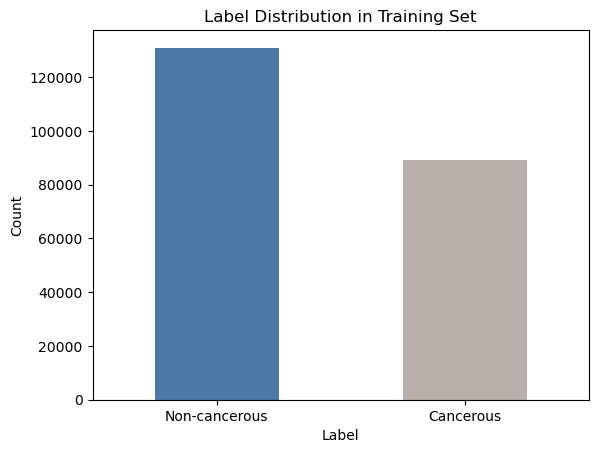

In [3]:
#EDA
#Distribution of cancerous (1) vs. non-cancerous (0) patches in train_labels.csv

# Define custom colors based on Tableau's color palette
colors = ['#4e79a7', '#bab0ab']  # Blue and light gray from Tableau colors

# Plot label distribution
label_counts = train_labels['label'].value_counts()
label_counts.plot(kind='bar', color=colors)
plt.title("Label Distribution in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-cancerous", "Cancerous"], rotation=0)
plt.show()


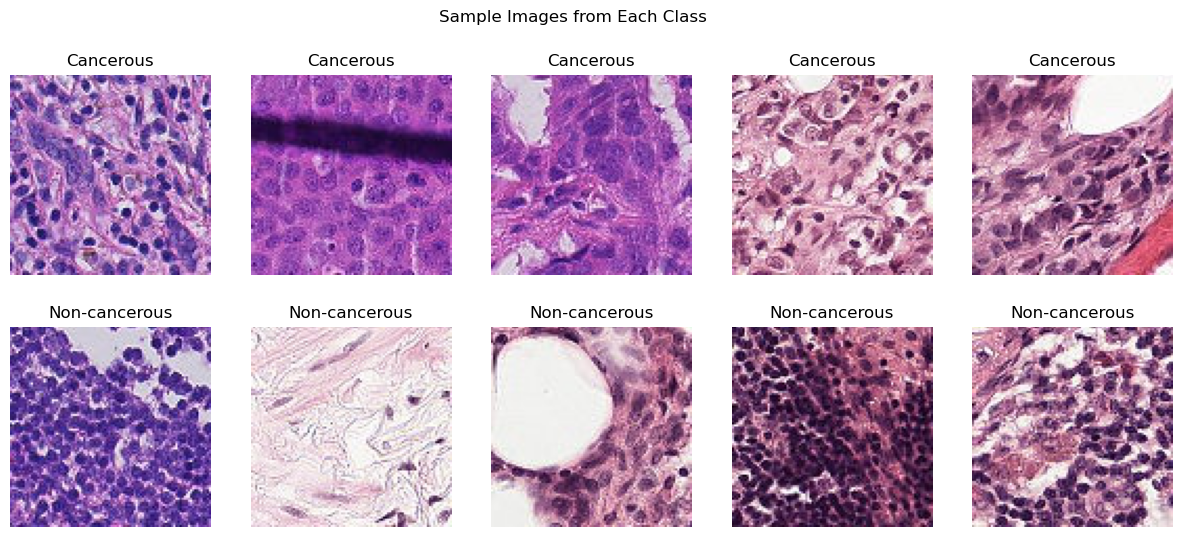

In [37]:
# Sample image visualization
# Function to load image as an array from the zip file
def load_image_from_zip(zip_path, image_name):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(f"train/{image_name}.tif") as image_file:
            img = Image.open(image_file)
            img_array = np.array(img)  # Convert to NumPy array
            return img_array  # Return the array representation of the image

# Sample image visualization code
sample_positive_ids = train_labels[train_labels['label'] == 1].sample(5)['id'].values
sample_negative_ids = train_labels[train_labels['label'] == 0].sample(5)['id'].values

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, image_id in enumerate(sample_positive_ids):
    img_array = load_image_from_zip(zip_file_path, image_id)
    axes[0, i].imshow(img_array)
    axes[0, i].set_title("Cancerous")
    axes[0, i].axis('off')

for i, image_id in enumerate(sample_negative_ids):
    img_array = load_image_from_zip(zip_file_path, image_id)
    axes[1, i].imshow(img_array)
    axes[1, i].set_title("Non-cancerous")
    axes[1, i].axis('off')

plt.suptitle("Sample Images from Each Class")
plt.show()


In [38]:
#Summary Statistics for Image Characteristics
#Goal: Get a general sense of the pixel intensity values and their distributions across both classes. 
#      This can help us decide if any normalization techniques are necessary.
def compute_simple_statistics(image_ids, zip_path, crop_size=32):
    stats = {"mean": [], "std": []}
    half_crop = crop_size // 2
    
    for image_id in image_ids:
        img_array = load_image_from_zip(zip_path, image_id)
        img_array = np.array(img_array) / 255.0  # Normalize pixel values to [0, 1]
        
        # Calculate the central crop
        center_x, center_y = img_array.shape[0] // 2, img_array.shape[1] // 2
        img_cropped = img_array[center_x - half_crop:center_x + half_crop, center_y - half_crop:center_y + half_crop]
        
        # Collect only mean and std of the central crop
        stats["mean"].append(img_cropped.mean())
        stats["std"].append(img_cropped.std())
        
    return {k: (np.mean(v), np.std(v)) for k, v in stats.items()}

# Using a reduced sample size, e.g., 50 images per class
sample_positive_ids = train_labels[train_labels['label'] == 1].sample(50)['id'].values
sample_negative_ids = train_labels[train_labels['label'] == 0].sample(50)['id'].values

positive_stats = compute_simple_statistics(sample_positive_ids, zip_file_path)
negative_stats = compute_simple_statistics(sample_negative_ids, zip_file_path)

print("Summary Statistics for Cancerous Patches:", positive_stats)
print("Summary Statistics for Non-cancerous Patches:", negative_stats)


Summary Statistics for Cancerous Patches: {'mean': (0.6172933261846404, 0.10716360910215669), 'std': (0.19798619203418116, 0.030024924636037717)}
Summary Statistics for Non-cancerous Patches: {'mean': (0.6729413041258171, 0.17464035401298442), 'std': (0.1914992232526972, 0.07010318330067453)}


## Insights from the Summary Statistics

### 1. Mean Intensity Comparison
- The mean pixel intensity for **cancerous patches** is `0.6173`, and for **non-cancerous patches** it is `0.6729`.
- This difference in mean values is notable, with non-cancerous patches tending to have slightly higher mean intensities. This suggests that non-cancerous patches might generally appear brighter, which could be a feature the model could potentially use.

### 2. Standard Deviation Comparison
- Cancerous Patches: Mean standard deviation is 0.1980, with a low variance across samples (0.0300).
- Non-cancerous Patches: Mean standard deviation is 0.1915, with a higher variance across samples (0.0701).
- The cancerous patches show a slightly higher average standard deviation but with less variability across samples. Non-cancerous patches, on the other hand, have a wider range of standard deviations, suggesting more variability in contrast levels.
- Given these values, **standardizing each image’s pixel values (Z-score normalization)** would help normalize the contrast differences between the two classes.

## Recommended Normalization Strategy

Based on these insights, **Z-score normalization** (mean subtraction and division by standard deviation for each image) is a suitable approach:
- Z-score normalization remains a good choice since it will help standardize the brightness and contrast levels across both classes.
- By applying Z-score normalization, we’ll make the intensity and contrast variations less class-dependent, helping the model focus on other visual features.


## Why We Need an Image Generator

An image generator is particularly useful for handling large image datasets in deep learning projects, as it helps manage memory usage and allows for efficient on-the-fly preprocessing. Here are the main reasons why an image generator is beneficial in this project:

### 1. Memory Efficiency
- Image datasets are often too large to load entirely into memory, especially for high-resolution or numerous images. A generator allows you to load only a subset of images (a batch) into memory at a time, significantly reducing memory usage.
- By loading images batch-by-batch, the generator ensures that only the images currently needed for training are stored in memory, freeing up resources for the model and preventing memory overload.

### 2. On-the-Fly Preprocessing
- With a generator, you can apply preprocessing steps, such as resizing, normalization, and data augmentation, directly to each batch of images as they are loaded.
- This is particularly useful in this project since the normalization technique (Z-score) was chosen based on the summary statistics. The generator can standardize images as they are fed into the model, making it convenient to consistently apply this preprocessing without creating separate preprocessed datasets.

### 3. Data Augmentation for Better Generalization
- Generators can include data augmentation techniques, such as rotation, flipping, zooming, and brightness adjustments. These techniques artificially expand the dataset by creating variations of each image, which can improve the model’s ability to generalize and reduce overfitting.
- In medical image analysis, data augmentation is valuable since capturing diverse real-world scenarios (different rotations, scales, brightness levels) can improve model robustness.

### 4. Compatibility with Model Training in Batches
- Generators allow images to be fed in batches, which aligns well with how deep learning models are trained. Processing images in batches also allows for efficient use of hardware resources, particularly GPUs, which are optimized for batch processing.
- The generator integrates seamlessly with Keras’ `.fit()` method, where it automatically provides batches to the model during training, making it straightforward to train the model with a large dataset.

### Summary

In summary, an image generator:
- **Manages memory** by loading images in batches.
- **Applies consistent preprocessing** (like normalization) on-the-fly.
- **Enhances model generalization** through data augmentation.
- **Aligns with batch-based model training**, optimizing resource usage.

In this project, the generator is key to maintaining efficient, consistent preprocessing and memory management, especially since the dataset is large and stored in a compressed format.


In [55]:
# define the image generator class
class ZipImageDataGenerator(Sequence):
    def __init__(self, zip_path, labels_df, batch_size=32, image_size=(96, 96), shuffle=True, normalization='zscore', folder='train'):
        self.zip_path = zip_path
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.labels_df))
        self.normalization = normalization  # Choose normalization method
        self.folder = folder  # Specify 'train' or 'test' folder
        
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.labels_df) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = []
        batch_labels = []

        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            for idx in batch_indices:
                image_id = self.labels_df.iloc[idx]['id']
                label = self.labels_df.iloc[idx]['label']

                # Load and resize image
                with zip_ref.open(f"{self.folder}/{image_id}.tif") as image_file:
                    img = Image.open(image_file)
                    img = img.resize(self.image_size)
                    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

                    # Apply the chosen normalization
                    if self.normalization == 'zscore':
                        img = (img - img.mean()) / (img.std() + 1e-8)  # Z-score normalization
                    elif self.normalization == 'minmax':
                        img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Min-max scaling to [0, 1]

                batch_data.append(img)
                batch_labels.append(label)

        return np.array(batch_data), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [56]:
# Instantiate the generator
batch_size = 128
image_size = (96, 96)

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_labels, test_size=0.2, random_state=42)

# Define training and validation generators
train_generator = ZipImageDataGenerator(
    zip_path=zip_file_path,
    labels_df=train_df,
    batch_size=batch_size,
    normalization='zscore'  # Apply Z-score normalization as discussed
)

validation_generator = ZipImageDataGenerator(
    zip_path=zip_file_path,
    labels_df=val_df,
    batch_size=batch_size,
    normalization='zscore'
)

# Example: Get a batch of images and labels
sample_images, sample_labels = train_generator[0]
print("Batch of images shape:", sample_images.shape)
print("Batch of labels shape:", sample_labels.shape)


Batch of images shape: (128, 96, 96, 3)
Batch of labels shape: (128,)


## Model Building and Training

### Define the Model Architecture
Since this is a binary image classification task, a Convolutional Neural Network (CNN) is a suitable choice. Here’s a suggested CNN architecture to start with:

**Convolutional Layers**: Use several convolutional layers with increasing filter sizes to capture patterns.</br>
**Pooling Layers**: Use max-pooling layers to reduce spatial dimensions and retain important features.</br>
**Fully Connected Layers**: At the end, add dense layers to process the features and make the final prediction.</br>
**Output Layer**: Use a single neuron with a sigmoid activation for binary classification.

In [39]:
def build_model(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

# Initialize the model
model = build_model()


### Compile the Model
After defining the model, compile it by specifying:

**Loss Function**: binary_crossentropy for binary classification.</br>
**Optimizer**: Adam is a popular choice for efficient training.</br>
**Metrics**: ROC-AUC or accuracy to monitor performance.

In [40]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Train the Model
To train the model, use the data generator to feed batches of images to the model during training.

**Epochs**: Start with a moderate number (e.g., 10-20 epochs) and increase if necessary.</br>
**Steps per Epoch**: Set this to the number of samples divided by batch size.</br>
**Validation**: Use a validation split or a separate generator for validation data to monitor overfitting.

**Use Early Stopping**</br>
Early stopping is a great way to stop training if the model’s validation performance stops improving, which saves both time and resources.

In [41]:
# Set training parameters
epochs = 10

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop if no improvement for 3 epochs
    restore_best_weights=True
)

# Calculate steps per epoch based on the training set size
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)


Epoch 1/10
1375/1375 [==============================] - 18203s 13s/step - loss: 0.4499 - accuracy: 0.8023 - val_loss: 0.3496 - val_accuracy: 0.8465
Epoch 2/10
1375/1375 [==============================] - 3001s 2s/step - loss: 0.3314 - accuracy: 0.8674 - val_loss: 0.2578 - val_accuracy: 0.8923
Epoch 3/10
1375/1375 [==============================] - 2992s 2s/step - loss: 0.2608 - accuracy: 0.9001 - val_loss: 0.2651 - val_accuracy: 0.8941
Epoch 4/10
1375/1375 [==============================] - 2991s 2s/step - loss: 0.2278 - accuracy: 0.9139 - val_loss: 0.2456 - val_accuracy: 0.8941
Epoch 5/10
1375/1375 [==============================] - 2995s 2s/step - loss: 0.2016 - accuracy: 0.9246 - val_loss: 0.1948 - val_accuracy: 0.9253
Epoch 6/10
1375/1375 [==============================] - 19335s 14s/step - loss: 0.1798 - accuracy: 0.9324 - val_loss: 0.1934 - val_accuracy: 0.9237
Epoch 7/10
1375/1375 [==============================] - 8838s 6s/step - loss: 0.1581 - accuracy: 0.9405 - val_loss: 0.18

### Observations from Training Output

1. **Initial Improvement**:
   - During the first few epochs, there’s a significant improvement in both training and validation loss and accuracy. This suggests that the model is learning meaningful patterns early on.
   - For example, between Epoch 1 and Epoch 2, the validation accuracy jumps from **0.8465** to **0.8923**, with a notable decrease in validation loss, indicating good learning progress.

2. **Model Performance Around Epoch 5**:
   - By Epoch 5, the model reaches a **validation accuracy of 0.9253** and a **validation loss of 0.1948**. The training accuracy is around **0.9246**, which is close to the validation accuracy, suggesting that the model is well-fitted to the training data at this point.

3. **Slight Overfitting Towards Later Epochs**:
   - Starting around Epoch 7, validation loss stops improving and begins to increase slightly, while training loss continues to decrease.
   - For example, by Epoch 10, the **validation loss rises to 0.2250** (from 0.1858 at Epoch 7), even as training loss reaches a new low of **0.1114**. This is a sign of **overfitting**, where the model is fitting well on the training data but struggles to generalize as effectively to validation data.
   - Despite the increase in validation loss, validation accuracy remains relatively stable (hovering around 0.9267-0.9322).

4. **Overall Accuracy**:
   - The model reaches a final **training accuracy of 0.9589** and a **validation accuracy of 0.9272**. These are strong results and indicate that the model can accurately classify most images, with a validation accuracy close to 93%.


### Evaluate the Model
After training, evaluate the model using the validation data to check performance on unseen data.

In [42]:
# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


343/343 [==============================] - 594s 2s/step - loss: 0.1857 - accuracy: 0.9322
Validation Loss: 0.18572448194026947
Validation Accuracy: 0.9321702122688293


he model achieved a notable results on the validation data:

- **Validation Loss**: `0.1857`
- **Validation Accuracy**: `93.22%`

### Interpretation

1. **High Validation Accuracy**:
   - A validation accuracy of **93.22%** indicates that the model is classifying most images correctly, suggesting that it has learned meaningful features for distinguishing between cancerous and non-cancerous patches.
   
2. **Validation Loss**:
   - The validation loss of **0.1857** is relatively low, which aligns well with the high accuracy. 


### Analyze Training Results
Plot the training and validation loss/accuracy over epochs to identify trends like overfitting or underfitting.

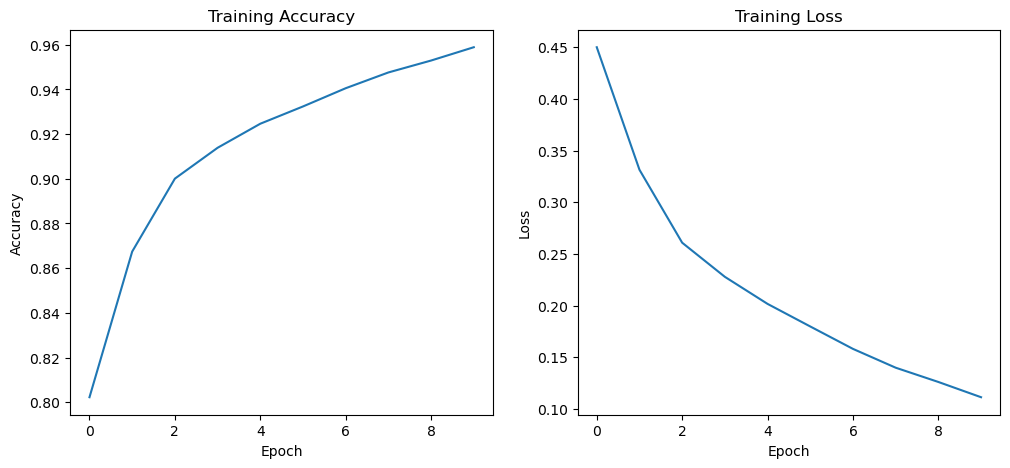

In [43]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.show()


In [50]:
# Extract the list of test image IDs
test_ids = []
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List all files in the 'test' folder within the zip file
    for file_info in zip_ref.infolist():
        if file_info.filename.startswith("test/") and file_info.filename.endswith(".tif"):
            # Extract the ID by removing the folder name and extension
            test_id = os.path.basename(file_info.filename).replace(".tif", "")
            test_ids.append(test_id)

print("Number of test IDs:", len(test_ids))
print("Sample test IDs:", test_ids[:5])

Number of test IDs: 57458
Sample test IDs: ['00006537328c33e284c973d7b39d340809f7271b', '0000ec92553fda4ce39889f9226ace43cae3364e', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2', '000253dfaa0be9d0d100283b22284ab2f6b643f6', '000270442cc15af719583a8172c87cd2bd9c7746']


In [77]:
class ZipTestImageDataGenerator(Sequence):
    def __init__(self, zip_path, image_ids, batch_size=32, image_size=(96, 96), normalization='zscore', folder='test'):
        self.zip_path = zip_path
        self.image_ids = image_ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.normalization = normalization
        self.folder = folder  # Specify the folder ('test' in this case)

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        # Get the IDs for the current batch
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = []

        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            for image_id in batch_ids:
                # Load and resize the image
                with zip_ref.open(f"{self.folder}/{image_id}.tif") as image_file:
                    img = Image.open(image_file)
                    img = img.resize(self.image_size)
                    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]

                    # Apply the chosen normalization
                    if self.normalization == 'zscore':
                        img = (img - img.mean()) / (img.std() + 1e-8)  # Z-score normalization
                    elif self.normalization == 'minmax':
                        img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Min-max scaling

                batch_data.append(img)

        return np.array(batch_data)


In [78]:
# Create a test data generator for loading test images
test_generator = ZipTestImageDataGenerator(
    zip_path=zip_file_path,
    image_ids=test_ids,       # List of test IDs
    batch_size=batch_size,
    normalization='zscore'
)

# Generate predictions
steps = int(np.ceil(len(test_ids) / batch_size))
predictions = model.predict(test_generator, steps = steps, verbose = 1)


449/449 [==============================] - 2006s 4s/step


In [80]:
min_length = min(len(test_ids), len(predictions))

#The model generated probability scores rather than binary labels (0 or 1). To match the required submission format, we need to convert these 
#probabilities into binary labels based on a chosen threshold, typically 0.5.
binary_predictions = (predictions[:min_length].flatten() >= 0.5).astype(int)

# `test_ids` is a list of IDs for test images and `predictions` contains the model's probabilities
# Save predictions to CSV
submission_df = pd.DataFrame({
    'id': test_ids[:min_length],
    'label': binary_predictions
})

submission_df.to_csv('submission.csv', index=False)
